In [1]:
%matplotlib inline
import time
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from PIL import Image

import sys
sys.path.append('..')
import d2lzh_pytorch as d2l
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if str(device).startswith('cuda'):
    device = torch.device('cuda:1' if torch.cuda.is_available() and torch.cuda.device_count() > 1 else 'cpu')

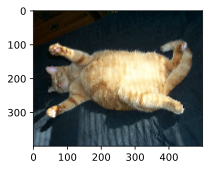

In [2]:
d2l.set_figsize()
img = Image.open('../img/cat1.jpg')
d2l.plt.imshow(img)

In [3]:
def show_images(imgs, num_rows, num_cols, scale=2):
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    for i in range(num_rows):
        for j in range(num_cols):
            axes[i][j].imshow(imgs[i * num_cols + j])
            axes[i][j].axes.get_xaxis().set_visible(False)
            axes[i][j].axes.get_yaxis().set_visible(False)
    return axes

In [4]:
def apply(img, aug, num_rows=2, num_cols=4, scale=1.5):
    Y = [aug(img) for _ in range(num_rows * num_cols)]
    show_images(Y, num_rows, num_cols, scale)

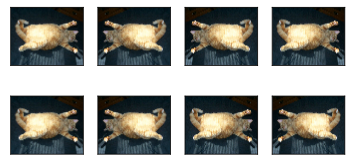

In [5]:
apply(img, torchvision.transforms.RandomHorizontalFlip())

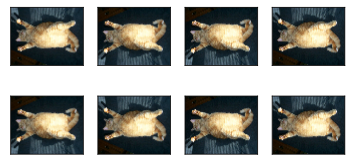

In [6]:
apply(img, torchvision.transforms.RandomVerticalFlip())

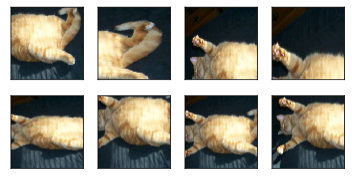

In [7]:
shape_aug = torchvision.transforms.RandomResizedCrop(200, scale=(0.1, 1), ratio=(0.5, 2))
apply(img, shape_aug)

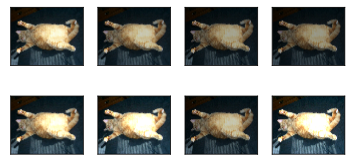

In [8]:
apply(img, torchvision.transforms.ColorJitter(brightness=0.5))

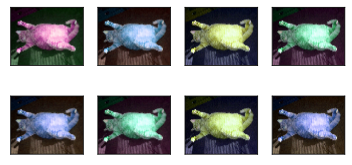

In [9]:
apply(img, torchvision.transforms.ColorJitter(hue=0.5))

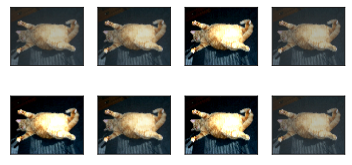

In [10]:
apply(img, torchvision.transforms.ColorJitter(contrast=0.5))

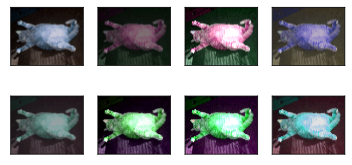

In [11]:
color_aug = torchvision.transforms.ColorJitter(
    brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)
apply(img, color_aug)

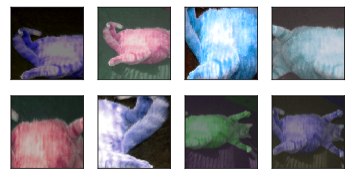

In [12]:
augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(), color_aug, shape_aug])
apply(img, augs)

Files already downloaded and verified


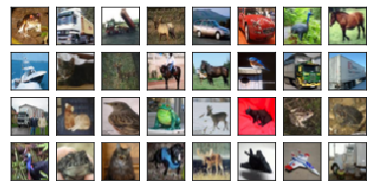

In [13]:
all_imges = torchvision.datasets.CIFAR10(train=True, root="../data/CIFAR", download=True)
# all_imges的每一个元素都是(image, label)
show_images([all_imges[i][0] for i in range(32)], 4, 8, scale=0.8);

In [14]:
flip_aug = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor()
])

no_aug = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

In [15]:
num_workers = 0 if sys.platform.startswith('win32') else 4
def load_cifar10(is_train, augs, batch_size, root='../data/CIFAR'):
    dataset = torchvision.datasets.CIFAR10(root=root, train=is_train, transform=augs, download=True)
    return DataLoader(dataset, batch_size=batch_size, shuffle=is_train, num_workers=num_workers)

In [16]:
def train(train_iter, test_iter, net, loss, optimizer, device, num_epochs):
    net = net.to(device)
    print('training on ', device)
    batch_count = 0
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        for X, y in train_iter:
            X = X.to(device)
            y = y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_l_sum += l.cpu().item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().cpu().item()
            n += y.shape[0]
            batch_count +=1
        test_acc = d2l.evaluate_accuracy(test_iter, net)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, time %.1f sec'
              % (epoch + 1, train_l_sum / batch_count, train_acc_sum / n, test_acc, time.time() - start))

In [19]:
def train_with_data_aug(train_augs, test_augs, lr=0.001):
    batch_size, net = 256, d2l.resnet18(10)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = torch.nn.CrossEntropyLoss()
    train_iter = load_cifar10(True, train_augs, batch_size)
    test_iter = load_cifar10(False, test_augs, batch_size)
    train(train_iter, test_iter, net, loss, optimizer, device, num_epochs=10)

In [20]:
train_with_data_aug(flip_aug, no_aug)

Files already downloaded and verified
Files already downloaded and verified
training on  cuda:1
epoch 1, loss 1.3979, train acc 0.496, test acc 0.427, time 9.9 sec
epoch 2, loss 0.5047, train acc 0.641, test acc 0.457, time 9.9 sec
epoch 3, loss 0.2888, train acc 0.696, test acc 0.669, time 10.0 sec
epoch 4, loss 0.1888, train acc 0.736, test acc 0.644, time 10.0 sec
epoch 5, loss 0.1353, train acc 0.764, test acc 0.622, time 10.1 sec
epoch 6, loss 0.1021, train acc 0.786, test acc 0.700, time 10.6 sec
epoch 7, loss 0.0805, train acc 0.804, test acc 0.735, time 10.7 sec
epoch 8, loss 0.0640, train acc 0.823, test acc 0.720, time 10.6 sec
epoch 9, loss 0.0526, train acc 0.837, test acc 0.693, time 10.7 sec
epoch 10, loss 0.0441, train acc 0.847, test acc 0.744, time 10.8 sec
